# 2. YOLO 실습


![대체 텍스트](https://github.com/computational-intelligence-lab/pytorch_CNN_YOLO_tutorial/blob/master/imgs/intro.PNG?raw=true)


In [0]:
"""
@author: Viet Nguyen <nhviet1009@gmail.com>
"""
from collections import OrderedDict as odict
from collections import defaultdict

import time
import datetime
import random
from random import uniform

import math
import os

import cv2
import numpy as np
import xml.etree.ElementTree as ET

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
from torchvision import transforms as T

from tqdm import tqdm
%matplotlib inline
from matplotlib import pyplot as plt

# 미리 학습된 Tiny YOLO 다운로드


본 튜토리얼은 시간관계상 ImageNet에서 pretrain된 darknet-converted.pth 에서 80epoch 훈련된 모델부터 실습을 진행합니다.

In [12]:

# !wget http://ai.jbnu.ac.kr/wp-content/uploads/2019/10/darknet-converted.pth
!wget http://ai.jbnu.ac.kr/wp-content/uploads/2019/10/yolo-v2-tiny-voc-e80.pth
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
!tar xf VOCtrainval_11-May-2012.tar

--2019-10-07 09:16:32--  http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/x-tar]
Saving to: ‘VOCtrainval_11-May-2012.tar’

VOCtrainval_11-May- 100%[===================>]   1.86G  4.49MB/s    in 6m 34s  

2019-10-07 09:23:06 (4.85 MB/s) - ‘VOCtrainval_11-May-2012.tar’ saved [1999639040/1999639040]



# Image Augmentation Code


4가지 Augmentation functions 

![대체 텍스트](https://cdn-images-1.medium.com/max/1000/1*C8hNiOqur4OJyEZmC7OnzQ.png)

In [0]:
def custom_collate_fn(batch):
    items = list(zip(*batch))
    items[0] = default_collate(items[0])
    items[1] = list(items[1])
    return items

  
class Compose(object):

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, data):
        for function_ in self.transforms:
            data = function_(data)
        return data


class Crop(object):

    def __init__(self, max_crop=0.1):
        super().__init__()
        self.max_crop = max_crop

    def __call__(self, data):
        image, label = data
        height, width = image.shape[:2]
        xmin = width
        ymin = height
        xmax = 0
        ymax = 0
        for lb in label:
            xmin = min(xmin, lb[0])
            ymin = min(ymin, lb[1])
            xmax = max(xmax, lb[2])
            ymax = max(ymax, lb[2])
        cropped_left = uniform(0, self.max_crop)
        cropped_right = uniform(0, self.max_crop)
        cropped_top = uniform(0, self.max_crop)
        cropped_bottom = uniform(0, self.max_crop)
        new_xmin = int(min(cropped_left * width, xmin))
        new_ymin = int(min(cropped_top * height, ymin))
        new_xmax = int(max(width - 1 - cropped_right * width, xmax))
        new_ymax = int(max(height - 1 - cropped_bottom * height, ymax))

        image = image[new_ymin:new_ymax, new_xmin:new_xmax, :]
        label = [[lb[0] - new_xmin, lb[1] - new_ymin, lb[2] - new_xmin, lb[3] - new_ymin, lb[4]] for lb in label]

        return image, label


class VerticalFlip(object):

    def __init__(self, prob=0.5):
        super().__init__()
        self.prob = prob

    def __call__(self, data):
        image, label = data
        if uniform(0, 1) >= self.prob:
            image = cv2.flip(image, 1)
            width = image.shape[1]
            label = [[width - lb[2], lb[1], width - lb[0], lb[3], lb[4]] for lb in label]
        return image, label


class HSVAdjust(object):

    def __init__(self, hue=30, saturation=1.5, value=1.5, prob=0.5):
        super().__init__()
        self.hue = hue
        self.saturation = saturation
        self.value = value
        self.prob = prob

    def __call__(self, data):

        def clip_hue(hue_channel):
            hue_channel[hue_channel >= 360] -= 360
            hue_channel[hue_channel < 0] += 360
            return hue_channel

        image, label = data
        adjust_hue = uniform(-self.hue, self.hue)
        adjust_saturation = uniform(1, self.saturation)
        if uniform(0, 1) >= self.prob:
            adjust_saturation = 1 / adjust_saturation
        adjust_value = uniform(1, self.value)
        if uniform(0, 1) >= self.prob:
            adjust_value = 1 / adjust_value
        image = image.astype(np.float32) / 255
        image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        image[:, :, 0] += adjust_hue
        image[:, :, 0] = clip_hue(image[:, :, 0])
        image[:, :, 1] = np.clip(adjust_saturation * image[:, :, 1], 0.0, 1.0)
        image[:, :, 2] = np.clip(adjust_value * image[:, :, 2], 0.0, 1.0)

        image = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)
        image = (image * 255).astype(np.float32)

        return image, label


class Resize(object):

    def __init__(self, image_size):
        super().__init__()
        self.image_size = image_size

    def __call__(self, data):
        image, label = data
        height, width = image.shape[:2]
        image = cv2.resize(image, (self.image_size, self.image_size))
        width_ratio = float(self.image_size) / width
        height_ratio = float(self.image_size) / height
        new_label = []
        for lb in label:
            resized_xmin = lb[0] * width_ratio
            resized_ymin = lb[1] * height_ratio
            resized_xmax = lb[2] * width_ratio
            resized_ymax = lb[3] * height_ratio
            resize_width = resized_xmax - resized_xmin
            resize_height = resized_ymax - resized_ymin
            new_label.append([resized_xmin, resized_ymin, resize_width, resize_height, lb[4]])

        return image, new_label

# Object detection bechmark Dataset : VOC2007

예시)
![대체 텍스트](http://host.robots.ox.ac.uk/pascal/VOC/voc2007/examples/aeroplane_03.jpg)

9,963개의 image에 20개의 class의 24,640개 object의 bounding box를 제공하는 Dataset

제공되는 VOC2007 Dataset의 입출력 정의.



In [0]:
class VOCDataset(Dataset):
    def __init__(self, root_path="data/VOCdevkit", year="2007", mode="train", image_size=448, is_training = True, transform=None):
        if (mode in ["train", "val", "trainval", "test"] and year == "2007") or (
                mode in ["train", "val", "trainval"] and year == "2012"):
            self.data_path = os.path.join(root_path, "VOC{}".format(year))
        id_list_path = os.path.join(self.data_path, "ImageSets/Main/{}.txt".format(mode))
        self.ids = [id.strip() for id in open(id_list_path)]
        self.classes = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
                        'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train',
                        'tvmonitor']
        self.image_size = image_size
        self.num_classes = len(self.classes)
        self.num_images = len(self.ids)
        self.is_training = is_training
        self.transform = transform

    def __len__(self):
        return self.num_images

    def __getitem__(self, item):
        id = self.ids[item]
        image_path = os.path.join(self.data_path, "JPEGImages", "{}.jpg".format(id))
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_xml_path = os.path.join(self.data_path, "Annotations", "{}.xml".format(id))
        annot = ET.parse(image_xml_path)

        objects = []
        for obj in annot.findall('object'):
            xmin, xmax, ymin, ymax = [int(obj.find('bndbox').find(tag).text) - 1 for tag in
                                      ["xmin", "xmax", "ymin", "ymax"]]
            label = self.classes.index(obj.find('name').text.lower().strip())
            objects.append([xmin, ymin, xmax, ymax, label])
        
        if self.transform is None:
            if self.is_training:
                transformations = Compose([HSVAdjust(), VerticalFlip(), Crop(), Resize(self.image_size)])
            else:
                transformations = Compose([Resize(self.image_size)])
            image, objects = transformations((image, objects))
        image = image / 255.
        return np.transpose(np.array(image, dtype=np.float32), (2, 0, 1)), np.array(objects, dtype=np.float32)

# TinyYOLO 구조도


![대체 텍스트](http://emaraic.com/assets/img/posts/machine-learning/yolo/tiny-yolo.png)

In [0]:
class TinyYolo(nn.Module):
    def __init__(self,
                 num_classes,
                 anchors=[(1.3221, 1.73145),
                          (3.19275, 4.00944),
                          (5.05587, 8.09892),
                          (9.47112, 4.84053),
                          (11.2364, 10.0071)]):
        super(TinyYolo, self).__init__()
        self.num_classes = num_classes
        self.anchors = anchors

        self.stage1_conv1 = nn.Sequential(
            nn.Conv2d(3, 16, 3, 1, 1, bias=False),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2, 2))

        self.stage1_conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, 1, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2, 2))

        self.stage1_conv3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, 1, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2, 2))

        self.stage1_conv4 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2, 2))

        self.stage1_conv5 = nn.Sequential(
            nn.Conv2d(128, 256, 3, 1, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2, 2))

        self.stage1_conv6 = nn.Sequential(
            nn.Conv2d(256, 512, 3, 1, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1, inplace=True))
        
        self.stage1_conv7 = nn.Sequential(
            nn.Conv2d(512, 1024, 3, 1, 1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1, inplace=True))
        
        self.stage2_conv1 = nn.Sequential(
            nn.Conv2d(1024, 1024, 3, 1, 1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1, inplace=True))
        
        num_output = len(self.anchors) * (5 + num_classes)
        self.stage2_conv2 = nn.Conv2d(1024, num_output, 1, 1, 0)

    def load_darknet_weight(self, f):
        w = torch.load(f)
        new_w = odict()
        for k in w.keys():
            if k.startswith('stage1'):
                new_w[k] = w[k]
        print(self.load_state_dict(new_w, strict=False))
        
    def forward(self, input):
        output = self.stage1_conv1(input)
        output = self.stage1_conv2(output)
        output = self.stage1_conv3(output)
        output = self.stage1_conv4(output)
        output = self.stage1_conv5(output)
        output = self.stage1_conv6(output)
        output = self.stage1_conv7(output)

        output = self.stage2_conv1(output)
        output = self.stage2_conv2(output)

        return output

In [0]:
class YoloLoss(nn.modules.loss._Loss):
    # The loss I borrow from LightNet repo.
    def __init__(self, num_classes, anchors, reduction=32, coord_scale=1.0, noobject_scale=1.0,
                 object_scale=5.0, class_scale=1.0, thresh=0.6):
        super(YoloLoss, self).__init__()
        self.num_classes = num_classes
        self.num_anchors = len(anchors)
        self.anchor_step = len(anchors[0])
        self.anchors = torch.Tensor(anchors)
        self.reduction = reduction

        self.coord_scale = coord_scale
        self.noobject_scale = noobject_scale
        self.object_scale = object_scale
        self.class_scale = class_scale
        self.thresh = thresh

    def forward(self, output, target):

        batch_size = output.data.size(0)
        height = output.data.size(2)
        width = output.data.size(3)

        # Get x,y,w,h,conf,cls
        output = output.view(batch_size, self.num_anchors, -1, height * width)
        coord = torch.zeros_like(output[:, :, :4, :])
        coord[:, :, :2, :] = output[:, :, :2, :].sigmoid()  
        coord[:, :, 2:4, :] = output[:, :, 2:4, :]
        conf = output[:, :, 4, :].sigmoid()
        cls = output[:, :, 5:, :].contiguous().view(batch_size * self.num_anchors, self.num_classes,
                                                    height * width).transpose(1, 2).contiguous().view(-1,
                                                                                                      self.num_classes)

        # Create prediction boxes
        pred_boxes = torch.FloatTensor(batch_size * self.num_anchors * height * width, 4)
        lin_x = torch.arange(0, width).repeat(height, 1).view(height * width).float()
        lin_y = torch.arange(0, height).repeat(width, 1).t().contiguous().view(height * width).float()
        anchor_w = self.anchors[:, 0].contiguous().view(self.num_anchors, 1)
        anchor_h = self.anchors[:, 1].contiguous().view(self.num_anchors, 1)

        if torch.cuda.is_available():
            pred_boxes = pred_boxes.cuda()
            lin_x = lin_x.cuda()
            lin_y = lin_y.cuda()
            anchor_w = anchor_w.cuda()
            anchor_h = anchor_h.cuda()

        pred_boxes[:, 0] = (coord[:, :, 0].detach() + lin_x).view(-1)
        pred_boxes[:, 1] = (coord[:, :, 1].detach() + lin_y).view(-1)
        pred_boxes[:, 2] = (coord[:, :, 2].detach().exp() * anchor_w).view(-1)
        pred_boxes[:, 3] = (coord[:, :, 3].detach().exp() * anchor_h).view(-1)
        pred_boxes = pred_boxes.cpu()

        # Get target values
        coord_mask, conf_mask, cls_mask, tcoord, tconf, tcls = self.build_targets(pred_boxes, target, height, width)
        coord_mask = coord_mask.expand_as(tcoord)
        tcls = tcls[cls_mask].view(-1).long()
        cls_mask = cls_mask.view(-1, 1).repeat(1, self.num_classes)

        if torch.cuda.is_available():
            tcoord = tcoord.cuda()
            tconf = tconf.cuda()
            coord_mask = coord_mask.cuda()
            conf_mask = conf_mask.cuda()
            tcls = tcls.cuda()
            cls_mask = cls_mask.cuda()

        conf_mask = conf_mask.sqrt()
        cls = cls[cls_mask].view(-1, self.num_classes)

        # Compute losses
        mse = nn.MSELoss(reduction='sum')
        ce = nn.CrossEntropyLoss(reduction='sum')
        self.loss_coord = self.coord_scale * mse(coord * coord_mask, tcoord * coord_mask) / batch_size
        self.loss_conf = mse(conf * conf_mask, tconf * conf_mask) / batch_size
        self.loss_cls = self.class_scale * 2 * ce(cls, tcls) / batch_size
        self.loss_tot = self.loss_coord + self.loss_conf + self.loss_cls

        return self.loss_tot, self.loss_coord, self.loss_conf, self.loss_cls

    def build_targets(self, pred_boxes, ground_truth, height, width):
        batch_size = len(ground_truth)

        conf_mask = torch.ones(batch_size, self.num_anchors, height * width, requires_grad=False) * self.noobject_scale
        coord_mask = torch.zeros(batch_size, self.num_anchors, 1, height * width, requires_grad=False)
        cls_mask = torch.zeros(batch_size, self.num_anchors, height * width, requires_grad=False).byte()
        tcoord = torch.zeros(batch_size, self.num_anchors, 4, height * width, requires_grad=False)
        tconf = torch.zeros(batch_size, self.num_anchors, height * width, requires_grad=False)
        tcls = torch.zeros(batch_size, self.num_anchors, height * width, requires_grad=False)

        for b in range(batch_size):
            if len(ground_truth[b]) == 0:
                continue

            # Build up tensors
            cur_pred_boxes = pred_boxes[
                             b * (self.num_anchors * height * width):(b + 1) * (self.num_anchors * height * width)]
            if self.anchor_step == 4:
                anchors = self.anchors.clone()
                anchors[:, :2] = 0
            else:
                anchors = torch.cat([torch.zeros_like(self.anchors), self.anchors], 1)
            gt = torch.zeros(len(ground_truth[b]), 4)
            for i, anno in enumerate(ground_truth[b]):
                gt[i, 0] = (anno[0] + anno[2] / 2) / self.reduction
                gt[i, 1] = (anno[1] + anno[3] / 2) / self.reduction
                gt[i, 2] = anno[2] / self.reduction
                gt[i, 3] = anno[3] / self.reduction

            # Set confidence mask of matching detections to 0
            iou_gt_pred = bbox_ious(gt, cur_pred_boxes)
            mask = (iou_gt_pred > self.thresh).sum(0) >= 1
            conf_mask[b][mask.view_as(conf_mask[b])] = 0

            # Find best anchor for each ground truth
            gt_wh = gt.clone()
            gt_wh[:, :2] = 0
            iou_gt_anchors = bbox_ious(gt_wh, anchors)
            _, best_anchors = iou_gt_anchors.max(1)

            # Set masks and target values for each ground truth
            for i, anno in enumerate(ground_truth[b]):
                gi = min(width - 1, max(0, int(gt[i, 0])))
                gj = min(height - 1, max(0, int(gt[i, 1])))
                best_n = best_anchors[i]
                iou = iou_gt_pred[i][best_n * height * width + gj * width + gi]
                coord_mask[b][best_n][0][gj * width + gi] = 1
                cls_mask[b][best_n][gj * width + gi] = 1
                conf_mask[b][best_n][gj * width + gi] = self.object_scale
                tcoord[b][best_n][0][gj * width + gi] = gt[i, 0] - gi
                tcoord[b][best_n][1][gj * width + gi] = gt[i, 1] - gj
                tcoord[b][best_n][2][gj * width + gi] = math.log(max(gt[i, 2], 1.0) / self.anchors[best_n, 0])
                tcoord[b][best_n][3][gj * width + gi] = math.log(max(gt[i, 3], 1.0) / self.anchors[best_n, 1])
                tconf[b][best_n][gj * width + gi] = iou
                tcls[b][best_n][gj * width + gi] = int(anno[4])

        return coord_mask, conf_mask, cls_mask, tcoord, tconf, tcls


def bbox_ious(boxes1, boxes2):
    b1x1, b1y1 = (boxes1[:, :2] - (boxes1[:, 2:4] / 2)).split(1, 1)
    b1x2, b1y2 = (boxes1[:, :2] + (boxes1[:, 2:4] / 2)).split(1, 1)
    b2x1, b2y1 = (boxes2[:, :2] - (boxes2[:, 2:4] / 2)).split(1, 1)
    b2x2, b2y2 = (boxes2[:, :2] + (boxes2[:, 2:4] / 2)).split(1, 1)

    dx = (b1x2.min(b2x2.t()) - b1x1.max(b2x1.t())).clamp(min=0)
    dy = (b1y2.min(b2y2.t()) - b1y1.max(b2y1.t())).clamp(min=0)
    intersections = dx * dy

    areas1 = (b1x2 - b1x1) * (b1y2 - b1y1)
    areas2 = (b2x2 - b2x1) * (b2y2 - b2y1)
    unions = (areas1 + areas2.t()) - intersections

    return intersections / unions

In [0]:
def prepare_batch(batch):
    x, y = batch
    return x.to('cuda', non_blocking=True), y

def adjust_learning_rate(epoch, optimizer, learning_rate_schedule):
    if str(epoch) in learning_rate_schedule.keys():
        for param_group in optimizer.param_groups:
            param_group['lr'] = learning_rate_schedule[str(epoch)]

def train(model, epoch, loader, optimizer, criterion):
    lossdict = defaultdict(list)
    model.train()
#     pbar = tqdm(total=len(loader), desc=f'Epoch {epoch} training')
    for i, batch in enumerate(loader):
        image, label = prepare_batch(batch)
        optimizer.zero_grad()

        logits = model(image)
        loss, loss_coord, loss_conf, loss_cls = criterion(logits, label)
        loss.backward()
        optimizer.step()
        if (i % 20) == 0:
            print(f'Epoch {epoch}, Iteration: {i}/{len(loader)}, '
                f'Lr: {optimizer.param_groups[0]["lr"]}, '
                f'Loss: {loss.item():.3f}, '
                f'(Coord: {loss_coord.item():.3f} '
                f'Conf: {loss_conf.item():.3f} '
                f'Cls: {loss_cls.item():.3f})')
#         pbar.set_description(f'Epoch {epoch} training: loss {loss.item():.3f}')
        lossdict['total'].append(loss.item())
        lossdict['coord'].append(loss_coord.item())
        lossdict['conf'].append(loss_conf.item())
        lossdict['cls'].append(loss_cls.item())
#         pbar.update()
#     pbar.close()
    return lossdict

@torch.no_grad()
def test(model, epoch, loader, criterion):
    model.eval()
    lossdict = defaultdict(list)
    loss_ls = []
    loss_coord_ls = []
    loss_conf_ls = []
    loss_cls_ls = []
#     pbar = tqdm(total=len(loader), desc=f'Epoch {epoch} testing')
    for i, batch in enumerate(loader):
        image, label = prepare_batch(batch)
        num_sample = len(label)

        logits = model(image)
        b_loss, b_loss_coord, b_loss_conf, b_loss_cls = criterion(logits, label)
        lossdict['total'].append((b_loss * num_sample).item())
        lossdict['coord'].append((b_loss_coord * num_sample).item())
        lossdict['conf'].append((b_loss_conf * num_sample).item())
        lossdict['cls'].append((b_loss_cls * num_sample).item())
#         pbar.update()
#     pbar.close()
    loss_total = sum(lossdict['total']) / len(loader.dataset)
    loss_coord = sum(lossdict['coord']) / len(loader.dataset)
    loss_conf = sum(lossdict['conf']) / len(loader.dataset)
    loss_cls = sum(lossdict['cls']) / len(loader.dataset)
    print(f'Epoch: {epoch}, '
          f'Loss:{loss_total:.2f} '
          f'(Coord:{loss_coord:.2f} Conf:{loss_conf:.2f} Cls:{loss_cls:.2f})')
    return dict(total=loss_total, coord=loss_coord, conf=loss_conf, cls=loss_cls)

In [0]:
def main(opt):
    if torch.cuda.is_available():
        torch.cuda.manual_seed(123)
    else:
        torch.manual_seed(123)
    learning_rate_schedule = {"0": 1e-4, "2": 1e-3,
                              "40": 1e-4, "60": 1e-5}
    training_params = {"batch_size": opt.batch_size,
                       "shuffle": True,
                       "drop_last": True,
                       "collate_fn": custom_collate_fn}

    test_params = {"batch_size": opt.batch_size,
                   "shuffle": False,
                   "drop_last": False,
                   "collate_fn": custom_collate_fn}

    training_set = VOCDataset(opt.data_path, opt.year, opt.train_set, opt.image_size)
    training_generator = DataLoader(training_set, **training_params)

    test_set = VOCDataset(opt.data_path, opt.year, opt.test_set, opt.image_size, is_training=False)
    test_generator = DataLoader(test_set, **test_params)

    model = TinyYolo(training_set.num_classes)
    model.load_darknet_weight(opt.pre_trained_model_path)
    model.to('cuda')
    
    nn.init.normal_(list(model.modules())[-1].weight, 0, 0.01)

    criterion = YoloLoss(training_set.num_classes, model.anchors, opt.reduction)
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-5, momentum=opt.momentum, weight_decay=opt.decay)
    best_loss = 1e10
    best_epoch = 0
    num_iter_per_epoch = len(training_generator)

    training_results = defaultdict(list)
    test_results = defaultdict(list)
    timer = defaultdict(int)
    for epoch in range(opt.num_epoches+1):
        timer['epoch'] = time.time()
        adjust_learning_rate(epoch, optimizer, learning_rate_schedule)
            
        training_result = train(
            model, epoch, training_generator, optimizer, criterion)
        for k, v in training_result.items():
            training_results[k].extend(v)

        if epoch % opt.test_interval == 0:
            test_result = test(model, epoch, test_generator, criterion)
            for k, v in test_result.items():
                test_results[k].append(v)
        if epoch % 10 == 0:
            torch.save(model.state_dict(), f'yolo-v2-tiny-voc-e{epoch}.pth')
        
        timer['total'] += time.time() - timer['epoch']
        elapse = datetime.timedelta(seconds=int(timer['total']))
        eta = datetime.timedelta(seconds=int(timer['total'] / (epoch+1) * (opt.num_epoches-epoch)))
        print(f'time elapse {elapse}, eta {eta}')
    return model, training_results, test_results

In [0]:
def get_args():
    class Args():
      pass
    args = Args()
    args.image_size = 448
    args.batch_size = 64
    args.momentum = 0.9
    args.decay = 0.0005
    args.dropout = 0.5
    args.num_epoches = 80
    args.test_interval = 5
    args.object_scale = 1.0
    args.noobject_scale = 0.5
    args.class_scale = 1.0
    args.coord_scale = 5.0
    args.reduction = 32
    args.es_min_delta = 0.0
    args.es_patience = 0
    args.train_set = "train"
    args.test_set = "val"
    args.year = "2012"
    args.data_path = "VOCdevkit"
    args.pre_trained_model_path = 'darknet-converted.pth'
#     args.log_path = "tensorboard/yolo_voc"
#     args.saved_path = "trained_models"

    return args

In [0]:
# model, training_results, test_results = main(get_args())

In [33]:
# import warnings
# warnings.filterwarnings('ignore')
# def get_args():
#     class Args():
#       pass
#     args = Args()
#     args.image_size = 448
#     args.batch_size = 64
#     args.momentum = 0.9
#     args.decay = 0.0005
#     args.dropout = 0.5
#     args.num_epoches = 80
#     args.test_interval = 5
#     args.object_scale = 1.0
#     args.noobject_scale = 0.5
#     args.class_scale = 1.0
#     args.coord_scale = 5.0
#     args.reduction = 32
#     args.es_min_delta = 0.0
#     args.es_patience = 0
#     args.train_set = "train"
#     args.test_set = "val"
#     args.year = "2012"
#     args.data_path = "VOCdevkit"
#     args.pre_trained_model_path = 'yolo-v2-tiny-voc-e80.pth'
# #     args.log_path = "tensorboard/yolo_voc"
# #     args.saved_path = "trained_models"

#     return args
# model, training_results, test_results = main(get_args())

_IncompatibleKeys(missing_keys=['stage2_conv1.0.weight', 'stage2_conv1.1.weight', 'stage2_conv1.1.bias', 'stage2_conv1.1.running_mean', 'stage2_conv1.1.running_var', 'stage2_conv2.weight', 'stage2_conv2.bias'], unexpected_keys=[])
Epoch 0, Iteration: 0/89, Lr: 0.0001, Loss: 255.239, (Coord: 1.625 Conf: 236.199 Cls: 17.415)


KeyboardInterrupt: ignored

NameError: ignored

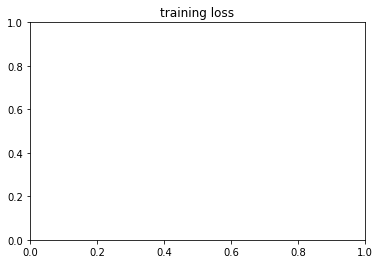

In [32]:
# %matplotlib inline
# from matplotlib import pyplot as plt
# plt.figure()
# plt.title('training loss')
# line_total, = plt.plot(training_results['total'], label='total')
# line_coord, = plt.plot(training_results['coord'], label='coord')
# line_conf, = plt.plot(training_results['conf'], label='conf')
# line_cls, = plt.plot(training_results['cls'], label='cls')
# plt.ylim(0, 25)
# plt.legend(handles=[line_total, line_coord, line_conf, line_cls])
# plt.show()

In [0]:
# plt.figure()
# plt.title('test loss')
# line_total, = plt.plot(test_results['total'], label='total')
# line_coord, = plt.plot(test_results['coord'], label='coord')
# line_conf, = plt.plot(test_results['conf'], label='conf')
# line_cls, = plt.plot(test_results['cls'], label='cls')
# plt.ylim(0, 20)
# plt.legend(handles=[line_total, line_coord, line_conf, line_cls])
# plt.show()

In [0]:
def post_processing(logits, image_size, gt_classes, anchors, conf_threshold, nms_threshold):
    num_anchors = len(anchors)
    anchors = torch.Tensor(anchors)

    if logits.dim() == 3:
        logits.unsqueeze_(0)

    batch = logits.size(0)
    h = logits.size(2)
    w = logits.size(3)

    # Compute xc,yc, w,h, box_score on Tensor
    lin_x = torch.linspace(0, w - 1, w).repeat(h, 1).view(h * w)
    lin_y = torch.linspace(0, h - 1, h).repeat(w, 1).t().contiguous().view(h * w)
    anchor_w = anchors[:, 0].contiguous().view(1, num_anchors, 1)
    anchor_h = anchors[:, 1].contiguous().view(1, num_anchors, 1)
    if torch.cuda.is_available():
        lin_x = lin_x.cuda()
        lin_y = lin_y.cuda()
        anchor_w = anchor_w.cuda()
        anchor_h = anchor_h.cuda()

    logits = logits.view(batch, num_anchors, -1, h * w)
    logits[:, :, 0, :].sigmoid_().add_(lin_x).div_(w)
    logits[:, :, 1, :].sigmoid_().add_(lin_y).div_(h)
    logits[:, :, 2, :].exp_().mul_(anchor_w).div_(w)
    logits[:, :, 3, :].exp_().mul_(anchor_h).div_(h)
    logits[:, :, 4, :].sigmoid_()

    with torch.no_grad():
        cls_scores = torch.nn.functional.softmax(logits[:, :, 5:, :], 2)
    cls_max, cls_max_idx = torch.max(cls_scores, 2)
    cls_max_idx = cls_max_idx.float()
    cls_max.mul_(logits[:, :, 4, :])

    score_thresh = cls_max > conf_threshold
    score_thresh_flat = score_thresh.view(-1)

    if score_thresh.sum() == 0:
        predicted_boxes = []
        for i in range(batch):
            predicted_boxes.append(torch.Tensor([]))
    else:
        coords = logits.transpose(2, 3)[..., 0:4]
        coords = coords[score_thresh[..., None].expand_as(coords)].view(-1, 4)
        scores = cls_max[score_thresh]
        idx = cls_max_idx[score_thresh]
        detections = torch.cat([coords, scores[:, None], idx[:, None]], dim=1)

        max_det_per_batch = num_anchors * h * w
        slices = [slice(max_det_per_batch * i, max_det_per_batch * (i + 1)) for i in range(batch)]
        det_per_batch = torch.IntTensor([score_thresh_flat[s].int().sum() for s in slices])
        split_idx = torch.cumsum(det_per_batch, dim=0)

        # Group detections per image of batch
        predicted_boxes = []
        start = 0
        for end in split_idx:
            predicted_boxes.append(detections[start: end])
            start = end

    selected_boxes = []
    for boxes in predicted_boxes:
        if boxes.numel() == 0:
            return boxes

        a = boxes[:, :2]
        b = boxes[:, 2:4]
        bboxes = torch.cat([a - b / 2, a + b / 2], 1)
        scores = boxes[:, 4]

        # Sort coordinates by descending score
        scores, order = scores.sort(0, descending=True)
        x1, y1, x2, y2 = bboxes[order].split(1, 1)

        # Compute dx and dy between each pair of boxes (these mat contain every pair twice...)
        dx = (x2.min(x2.t()) - x1.max(x1.t())).clamp(min=0)
        dy = (y2.min(y2.t()) - y1.max(y1.t())).clamp(min=0)

        # Compute iou
        intersections = dx * dy
        areas = (x2 - x1) * (y2 - y1)
        unions = (areas + areas.t()) - intersections
        ious = intersections / unions

        # Filter based on iou (and class)
        conflicting = (ious > nms_threshold).type(torch.uint8).triu(1)

        keep = conflicting.sum(0).byte()
        keep = keep.cpu()
        conflicting = conflicting.cpu()

        keep_len = len(keep) - 1
        for i in range(1, keep_len):
            if keep[i] > 0:
                keep -= conflicting[i]
        if torch.cuda.is_available():
            keep = keep.cuda()

        keep = (keep == 0)
        selected_boxes.append(boxes[order][keep[:, None].expand_as(boxes)].view(-1, 6).contiguous())

    final_boxes = []
    for boxes in selected_boxes:
        if boxes.dim() == 0:
            final_boxes.append([])
        else:
            boxes[:, 0:3:2] *= image_size
            boxes[:, 0] -= boxes[:, 2] / 2
            boxes[:, 1:4:2] *= image_size
            boxes[:, 1] -= boxes[:, 3] / 2

            final_boxes.append([[box[0].item(), box[1].item(), box[2].item(), box[3].item(), box[4].item(),
                                 gt_classes[int(box[5].item())]] for box in boxes])
    return final_boxes

In [0]:
model = TinyYolo(20)
model.load_state_dict(torch.load('yolo-v2-tiny-voc-e80.pth', 'cpu'))
model = model.to('cuda').eval()

colors = odict([
    ('aeroplane', (0.15, 0.51, 0.44)),
    ('bicycle', (0.64, 0.31, 0.52)),
    ('bird', (0.33, 0.48, 0.45)),
    ('boat', (0.39, 0.32, 0.67)),
    ('bottle', (0.37, 0.22, 0.41)),
    ('bus', (0.15, 0.33, 0.34)),
    ('car', (0.05, 0.35, 0.48)),
    ('cat', (0.31, 0.03, 0.25)),
    ('chair', (0.04, 0.40, 0.10)),
    ('cow', (0.35, 0.73, 0.43)),
    ('diningtable', (0.42, 0.43, 0.52)),
    ('dog', (0.66, 0.62, 0.33)),
    ('horse', (0.74, 0.73, 0.10)),
    ('motorbike', (0.40, 0.00, 0.07)),
    ('person', (0.32, 0.56, 0.32)),
    ('pottedplant', (0.36, 0.03, 0.72)),
    ('sheep', (0.19, 0.32, 0.61)),
    ('sofa', (0.70, 0.69, 0.27)),
    ('train', (0.36, 0.73, 0.62)),
    ('tvmonitor', (0.05, 0.15, 0.29)),
])

opts = get_args()
testset = VOCDataset(
    opts.data_path, opts.year, opts.test_set, opts.image_size, is_training=False, transform=lambda x: x)

class EvalLoader(object):
    def __init__(self, dataset, image_size):
        self.dataset = dataset
        self.image_size = image_size
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        original_image, label = self.dataset[idx]
        _, h, w = original_image.shape
        ratio = self.image_size / np.array([h,w])
        image = T.ToTensor()(T.ToPILImage()(torch.tensor(original_image)).resize((self.image_size,)*2))[None]
        return original_image.transpose(1,2,0), (h, w), ratio, image, label

class Detector(object):
    def __init__(self, model, evalloader, colors, conf_threshold, nms_threshold):
        self.model = model
        self.loader = loader
        self.colors = colors
        self.thresholds = [conf_threshold, nms_threshold]
    
    def draw_box(self, image, label, box, color, confidence=None):
        text = f'{label}'
        if confidence is not None:
            text += f': {confidence:.2f}'
        text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_PLAIN, 1, 1)[0]
        cv2.rectangle(image, box[0], box[1], color, 2)
        cv2.rectangle(image, box[0], (box[0][0] + text_size[0] + 3, box[0][1] + text_size[1] + 4), color, -1)
        cv2.putText(
            image, text, (box[0][0], box[0][1] + text_size[1] + 4), cv2.FONT_HERSHEY_PLAIN, 1, (1., 1., 1.,), 1)
                
    @torch.no_grad()
    def __call__(self, idx=None, direct_show=True):
        if idx is None:
            idx = random.randint(0, len(self.loader))
        
        output_image, (h, w), (hr, wr), im, label = self.loader[idx]
        original_image = output_image.copy()
        logits = self.model(im.to(next(self.model.parameters()).device))
        predictions = post_processing(
            logits, self.loader.image_size, list(colors.keys()),
            self.model.anchors, *self.thresholds)
        
        # draw prediction
        if len(predictions) != 0:
            predictions = predictions[0]
        
            for pred in predictions:
                xmin = int(max(pred[0] / wr, 0))
                ymin = int(max(pred[1] / hr, 0))
                xmax = int(min((pred[0] + pred[2]) / wr, w))
                ymax = int(min((pred[1] + pred[3]) / hr, h))
                color = colors[pred[5]]
                self.draw_box(output_image, pred[5], ((xmin, ymin), (xmax, ymax)), color, pred[4])
                print(f"Object: {pred[5]}, Bounding box: ({xmin},{xmax}) ({ymin},{ymax}), {pred[4]:.3f}")
        
        # draw ground truth
        for gt in label:
            name, color = list(colors.items())[int(gt[-1])]
            box = (tuple(gt[0:2].astype(int).tolist()),
                   tuple(gt[2:4].astype(int).tolist()))
            self.draw_box(original_image, name, box, color)
            
            
        if direct_show:
            figs, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,20))
            ax1, ax2 = axes.ravel()
            ax1.set_title('ground truth')
            ax1.axis('off')
            ax1.imshow(original_image)
            
            ax2.set_title('predicted')
            ax2.axis('off')
            ax2.imshow(output_image)
            
            plt.show()
            
        return output_image

In [0]:
loader = EvalLoader(testset, opts.image_size)
conf_threshold = 0.2
nms_threshold = 0.4
detector = Detector(model, loader, colors, conf_threshold, nms_threshold)

Object: chair, Bounding box: (291,367) (196,414), 0.581
Object: person, Bounding box: (0,26) (248,349), 0.338
Object: chair, Bounding box: (187,322) (165,433), 0.330
Object: chair, Bounding box: (77,152) (270,403), 0.317
Object: chair, Bounding box: (150,198) (302,435), 0.211


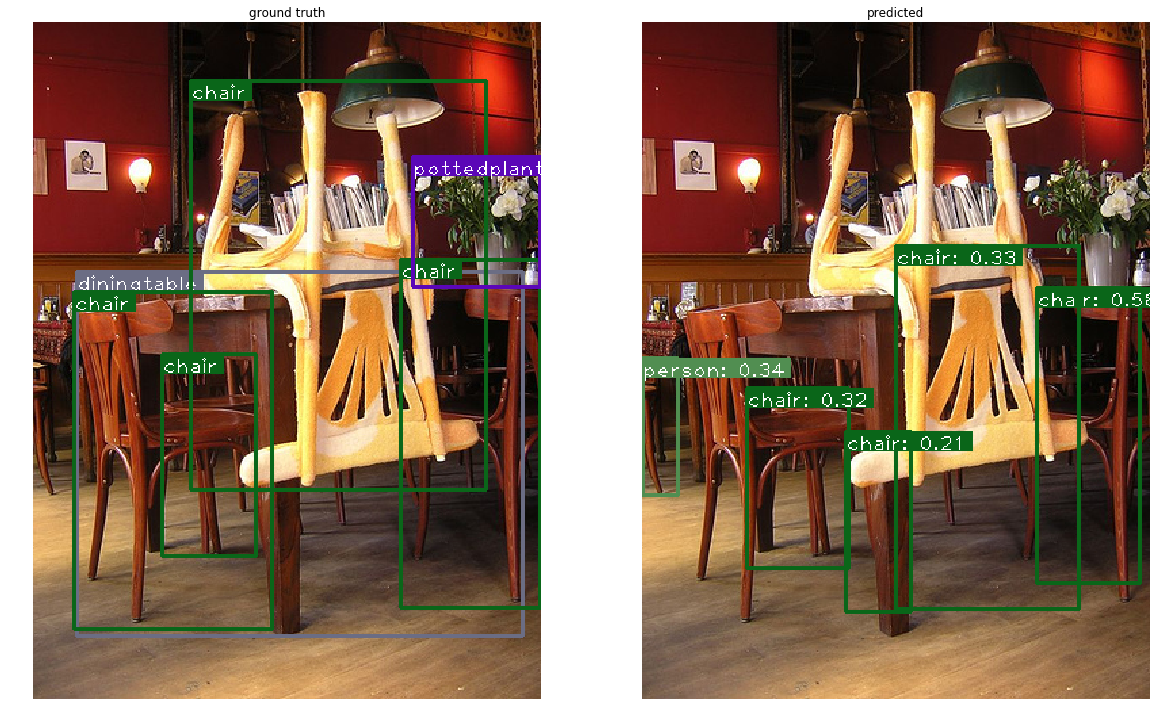

In [30]:
_ = detector()
